# Importação dos dados

In [1]:
from datetime import datetime
from dateutil.parser import parse

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from pylab import rcParams
rcParams['figure.figsize'] = 8, 6

In [2]:
atlas_mun = pd.read_csv("AtlasBrasil_IndicadoresSociais.csv", sep=";")
painel_covid = pd.read_csv("HIST_PAINEL_COVIDBR_18mai2020.csv", sep=";")
data_inloco = pd.read_csv("inloco_mun_1705.csv", sep=";")

## Dados Atlas Municipios

In [3]:
atlas_mun.head()

,Código,Espacialidades,Índice de Gini 2010,% de pessoas em domicílios com abastecimento de água e esgotamento sanitário inadequados 2010,IDHM Renda 2010,IDHM Educação 2010,Taxa de envelhecimento 2010,% de extremamente pobres 2010
0,76,Brasil,"0,6","6,12","0,739","0,637","7,36","6,62"
1,2400109,Acari,"0,49","2,06","0,633","0,634","9,88","5,18"
2,2400208,Açu,"0,53","10,49","0,641","0,568","6,99","7,68"
3,2400307,Afonso Bezerra,"0,53","18,03","0,56","0,502","9,22","21,79"
4,2400406,Água Nova,"0,44","3,11","0,527","0,572","7,65","17,77"


In [4]:
atlas_mun.describe()

,Código
count,1.680000e+02
mean,2.393316e+06
std,1.858000e+05
min,7.600000e+01
25%,2.403744e+06
50%,2.407554e+06
75%,2.411447e+06
max,2.415008e+06


## Dados Painel Covid

In [5]:
painel_covid.head()

,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,obitosAcumulado,Recuperadosnovos,emAcompanhamentoNovos
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,26/2/2020,9,210147125.0,1,0,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,27/2/2020,9,210147125.0,1,0,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,28/2/2020,9,210147125.0,1,0,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,29/2/2020,9,210147125.0,2,0,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,1/3/2020,10,210147125.0,2,0,NaN,NaN


In [6]:
painel_covid.describe()

,coduf,codmun,codRegiaoSaude,semanaEpi,populacaoTCU2019,casosAcumulado,obitosAcumulado,Recuperadosnovos,emAcompanhamentoNovos
count,88948.000000,87077.000000,86565.000000,88948.000000,8.843600e+04,88948.000000,88948.000000,30.000000,30.000000
mean,31.402066,315353.181839,31418.866413,18.210505,4.585535e+05,134.573009,8.973119,50573.233333,61677.866667
std,9.787037,96533.134654,9632.678067,1.928292,6.691023e+06,2731.557704,190.635494,23714.061350,38135.570372
min,11.000000,110000.000000,11001.000000,9.000000,1.112000e+03,1.000000,0.000000,22130.000000,14062.000000
25%,24.000000,241150.000000,24006.000000,17.000000,1.341000e+04,1.000000,0.000000,30399.500000,28352.250000
50%,31.000000,314800.000000,31056.000000,19.000000,2.867800e+04,3.000000,0.000000,44088.500000,53202.000000
75%,41.000000,410230.000000,41002.000000,20.000000,7.325400e+04,12.000000,1.000000,66777.250000,88726.500000
max,76.000000,530010.000000,53001.000000,21.000000,2.101471e+08,254220.000000,16792.000000,100459.000000,136969.000000


## Dados InLoco

In [7]:
data_inloco.head()

,City Name,Dt,Isolated_city
0,Vila Flor,17/05/2020,"41,40%"
1,Vila Flor,16/05/2020,"36,40%"
2,Vila Flor,15/05/2020,"47,90%"
3,Vila Flor,14/05/2020,"44,00%"
4,Vila Flor,13/05/2020,"41,90%"


In [8]:
data_inloco.describe()

,City Name,Dt,Isolated_city
count,107,107,107
unique,1,107,93
top,Vila Flor,29/03/2020,"37,20%"
freq,107,1,3


# Experimento 1 - Predição da quantidade total de casos no RN com base em valores pasados

#### Nesse experimento iremos utilizar apenas os valores passados de casos de corona virus para estimar qual será a quantidade de casos no futuro.

## Limpeza dos dados

In [9]:
atlas_mun_rn = atlas_mun.drop(atlas_mun.index[0])

In [10]:
painel_covid_rn = painel_covid[painel_covid.estado == "RN"]
painel_covid_rn = painel_covid_rn[pd.notna(painel_covid_rn.municipio)]

In [11]:
dates = np.unique(painel_covid_rn['data'])

cases = []

for date in dates:
  painel_covid_date = painel_covid_rn[painel_covid_rn.data == date]
  n_cases_date = painel_covid_date.aggregate('sum')['casosAcumulado']
  cases.append(n_cases_date)

formated_dates = [datetime.strptime(date, '%d/%m/%Y') for date in dates]

n_casos_rn = pd.DataFrame(data = {'dates': formated_dates, 'sumCases':cases })
n_casos_rn = n_casos_rn.sort_values(by=['dates'], ascending=True)
n_casos_rn = n_casos_rn.set_index('dates')

## Analise dos dados

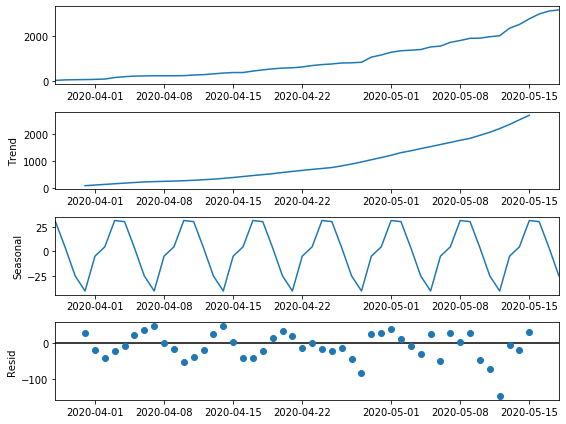

In [12]:
decomposition = sm.tsa.seasonal_decompose(n_casos_rn, model='additive')
fig = decomposition.plot()
plt.show()

## Criação de modelos

### Separação treino/validação/teste

In [13]:
length_data = n_casos_rn.shape[0]

size_train = int(0.7 * length_data)
size_val = int(0.2 * length_data)
size_test = int(0.1 * length_data)

indexes_samples_train = np.arange(0, size_train)
indexes_samples_val = np.arange(size_train, size_train + size_val)
indexes_samples_test = np.arange(size_train + size_val, size_train + size_val + size_test)

days = np.arange(length_data)

x_train = days[indexes_samples_train].reshape(-1,1)
x_val = days[indexes_samples_val].reshape(-1,1)
x_test = days[indexes_samples_test].reshape(-1,1)


y_train = n_casos_rn['sumCases'].to_numpy()[indexes_samples_train].reshape(-1,1)
y_val = n_casos_rn['sumCases'].to_numpy()[indexes_samples_val].reshape(-1,1)
y_test = n_casos_rn['sumCases'].to_numpy()[indexes_samples_test].reshape(-1,1)

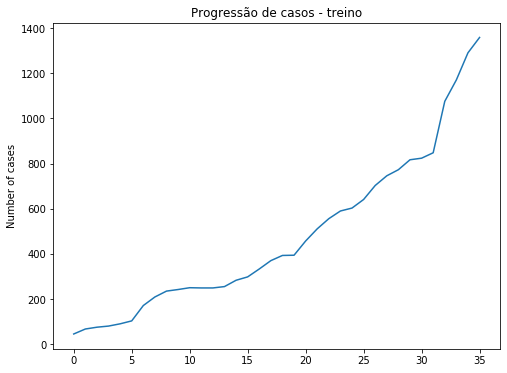

In [14]:
plt.plot(y_train)
plt.ylabel('Number of cases')
plt.title('Progressão de casos - treino')
plt.show()

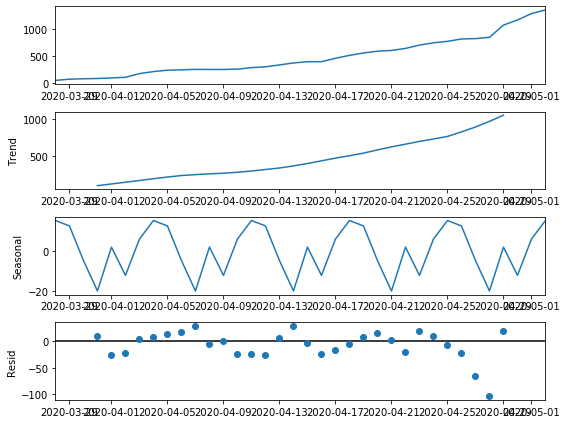

In [15]:
decomposition = sm.tsa.seasonal_decompose(n_casos_rn.iloc[indexes_samples_train], model='additive')
fig = decomposition.plot()
plt.show()

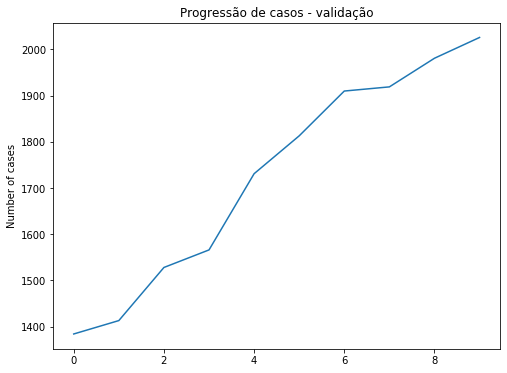

In [16]:
plt.plot(y_val)
plt.ylabel('Number of cases')
plt.title('Progressão de casos - validação')
plt.show()

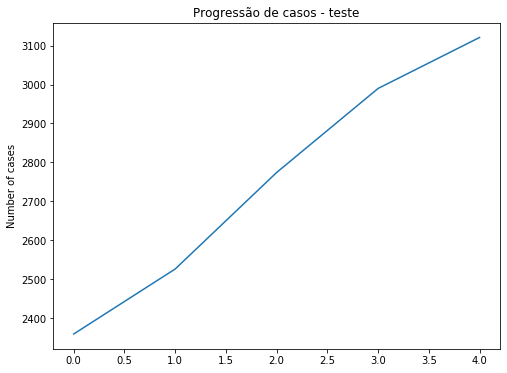

In [17]:
plt.plot(y_test)
plt.ylabel('Number of cases')
plt.title('Progressão de casos - teste')
plt.show()

In [18]:
# Devido ao tamanho da série de teste ser pequena, não é possível calcular a tendência

In [19]:
'''# Padronizando os valores
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
## Padronizando variáveis de treinamento
x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train)
## Padronizando variáveis de teste
x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test)
## Padronizando variáveis de validação
x_val = scaler.fit_transform(x_val)
y_val = scaler.fit_transform(y_val)'''

'# Padronizando os valores\nfrom sklearn.preprocessing import StandardScaler\nscaler = StandardScaler()\n## Padronizando variáveis de treinamento\nx_train = scaler.fit_transform(x_train)\ny_train = scaler.fit_transform(y_train)\n## Padronizando variáveis de teste\nx_test = scaler.fit_transform(x_test)\ny_test = scaler.fit_transform(y_test)\n## Padronizando variáveis de validação\nx_val = scaler.fit_transform(x_val)\ny_val = scaler.fit_transform(y_val)'

### Geração de regressão linear para baseline

---



In [20]:
lin_reg = LinearRegression()

lin_reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Mean squared error: 11694.95
Coefficient of determination: 0.91


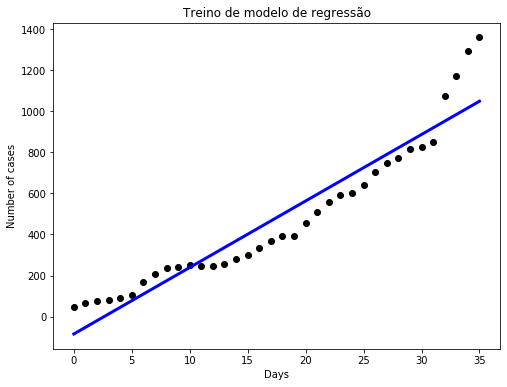

In [21]:
train_pred = lin_reg.predict(x_train)


print('Mean squared error: %.2f'
      % mean_squared_error(y_train, train_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, train_pred))

plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, train_pred, color='blue', linewidth=3)

plt.title("Treino de modelo de regressão")
plt.xlabel("Days")
plt.ylabel("Number of cases")

plt.show()

Mean squared error: 268962.93
Coefficient of determination: -4.24


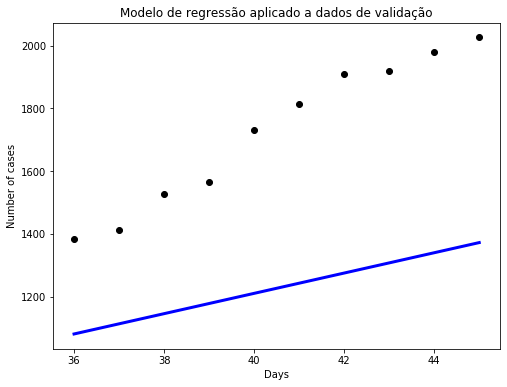

In [22]:
val_pred = lin_reg.predict(x_val)


print('Mean squared error: %.2f'
      % mean_squared_error(y_val, val_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_val, val_pred))

plt.scatter(x_val, y_val,  color='black')
plt.plot(x_val, val_pred, color='blue', linewidth=3)

plt.title("Modelo de regressão aplicado a dados de validação")
plt.xlabel("Days")
plt.ylabel("Number of cases")

plt.show()

Mean squared error: 1706350.28
Coefficient of determination: -20.39


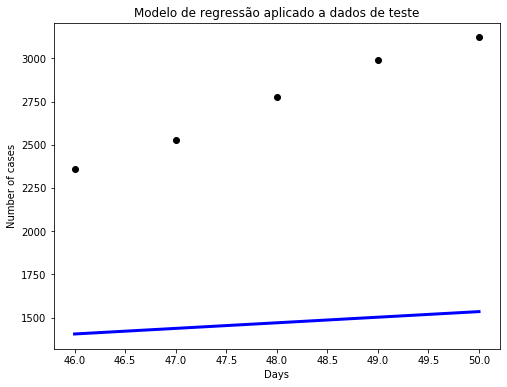

In [23]:
test_pred = lin_reg.predict(x_test)


print('Mean squared error: %.2f'
      % mean_squared_error(y_test, test_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, test_pred))

plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, test_pred, color='blue', linewidth=3)

plt.title("Modelo de regressão aplicado a dados de teste")
plt.xlabel("Days")
plt.ylabel("Number of cases")

plt.show()

### Modelo de regressão com SVM

---


In [24]:
regr = make_pipeline(SVR(degree=9, kernel='poly'))
regr.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=9, epsilon=0.1,
                     gamma='scale', kernel='poly', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Mean squared error: 35816.94
Coefficient of determination: 0.71


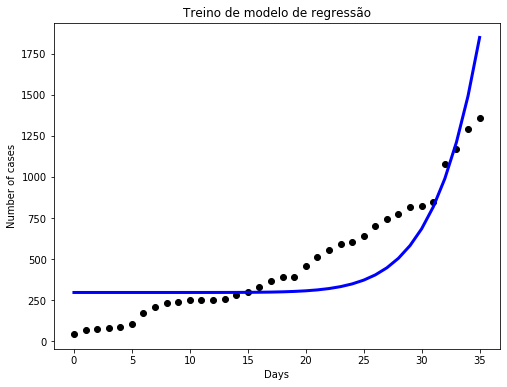

In [25]:
train_pred = regr.predict(x_train)


print('Mean squared error: %.2f'
      % mean_squared_error(y_train, train_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_train, train_pred))

plt.scatter(x_train, y_train,  color='black')
plt.plot(x_train, train_pred, color='blue', linewidth=3)

plt.title("Treino de modelo de regressão")
plt.xlabel("Days")
plt.ylabel("Number of cases")

plt.show()

Mean squared error: 44491766.64
Coefficient of determination: -865.53


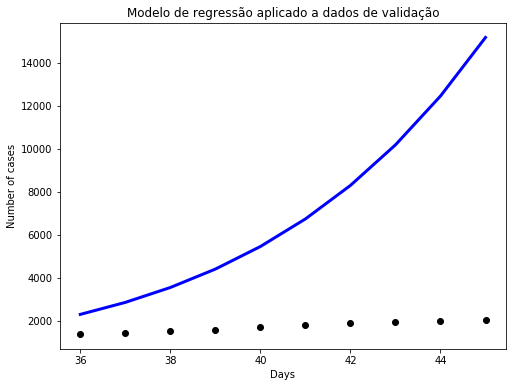

In [26]:
val_pred = regr.predict(x_val)


print('Mean squared error: %.2f'
      % mean_squared_error(y_val, val_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_val, val_pred))

plt.scatter(x_val, y_val,  color='black')
plt.plot(x_val, val_pred, color='blue', linewidth=3)

plt.title("Modelo de regressão aplicado a dados de validação")
plt.xlabel("Days")
plt.ylabel("Number of cases")

plt.show()

Mean squared error: 671848771.45
Coefficient of determination: -8422.51


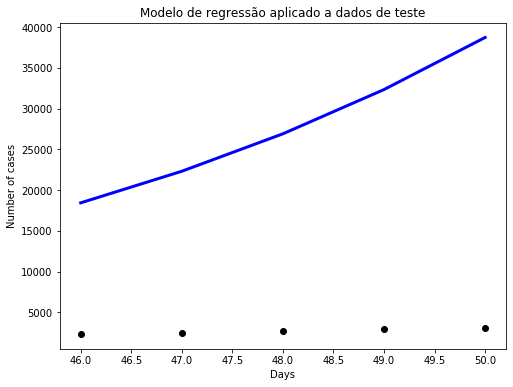

In [27]:
test_pred = regr.predict(x_test)


print('Mean squared error: %.2f'
      % mean_squared_error(y_test, test_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, test_pred))

plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, test_pred, color='blue', linewidth=3)

plt.title("Modelo de regressão aplicado a dados de teste")
plt.xlabel("Days")
plt.ylabel("Number of cases")

plt.show()

### Modelo de Regressão Polinomial

---


In [28]:
poly = PolynomialFeatures(degree = 2)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)
x_val_poly = poly.transform(x_val)

In [29]:
regressor = LinearRegression()
regressor.fit(x_train_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Mean Absolute Error: 40.899
Mean Squared Error: 2942.793
Coefficient of determination: 0.976


Text(0, 0.5, 'Number of cases')

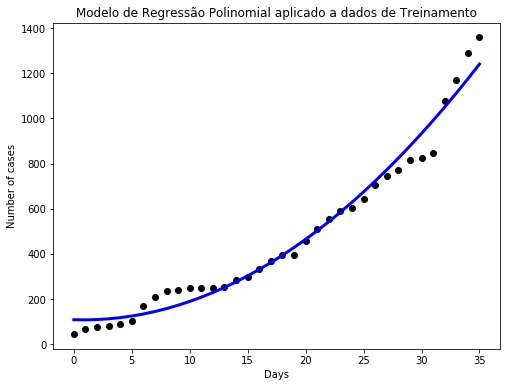

In [30]:
train_pred = regressor.predict(x_train_poly)

mae = mean_absolute_error(y_train, train_pred)
mse = mean_squared_error(y_train, train_pred)
coef_det = r2_score(y_train, train_pred)
print('Mean Absolute Error: {0:.3f}'.format(mae))
print('Mean Squared Error: {0:.3f}'.format(mse))
print('Coefficient of determination: {0:.3f}'.format(coef_det))

plt.scatter(x_train, y_train, color='black')
plt.plot(x_train, train_pred, color = 'blue', linewidth=3)
plt.title('Modelo de Regressão Polinomial aplicado a dados de Treinamento')
plt.xlabel('Days')
plt.ylabel('Number of cases')

Mean Absolute Error: 83.878
Mean Squared Error: 8918.828
Coefficient of determination: 0.826


Text(0, 0.5, 'Number of cases')

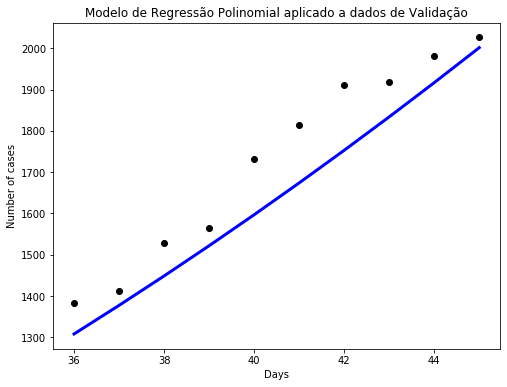

In [31]:
val_pred = regressor.predict(x_val_poly)

mae = mean_absolute_error(y_val, val_pred)
mse = mean_squared_error(y_val, val_pred)
coef_det = r2_score(y_val, val_pred)
print('Mean Absolute Error: {0:.3f}'.format(mae))
print('Mean Squared Error: {0:.3f}'.format(mse))
print('Coefficient of determination: {0:.3f}'.format(coef_det))

plt.scatter(x_val, y_val, color='black')
plt.plot(x_val, val_pred, color = 'blue', linewidth=3)
plt.title('Modelo de Regressão Polinomial aplicado a dados de Validação')
plt.xlabel('Days')
plt.ylabel('Number of cases')

Mean Absolute Error: 484.725
Mean Squared Error: 258717.743
Coefficient of determination: -2.244


Text(0, 0.5, 'Number of cases')

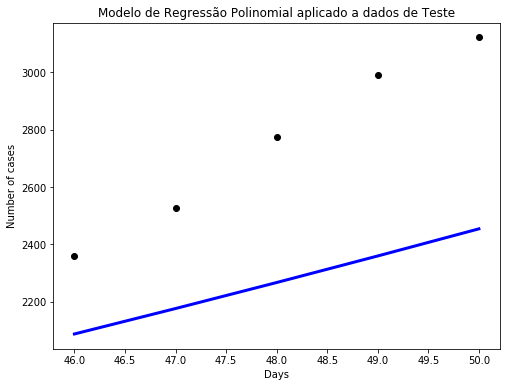

In [32]:
test_pred = regressor.predict(x_test_poly)

mae = mean_absolute_error(y_test, test_pred)
mse = mean_squared_error(y_test, test_pred)
coef_det = r2_score(y_test, test_pred)
print('Mean Absolute Error: {0:.3f}'.format(mae))
print('Mean Squared Error: {0:.3f}'.format(mse))
print('Coefficient of determination: {0:.3f}'.format(coef_det))

plt.scatter(x_test, y_test, color='black')
plt.plot(x_test, test_pred, color = 'blue', linewidth=3)
plt.title('Modelo de Regressão Polinomial aplicado a dados de Teste')
plt.xlabel('Days')
plt.ylabel('Number of cases')

### Modelo de regressão com Random Forest

---

In [33]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=50, criterion=)
regressor.fit(x_train, y_train)

SyntaxError: invalid syntax (<ipython-input-33-a93affb247fa>, line 3)

In [34]:
train_pred = regressor.predict(x_train)

mae = mean_absolute_error(y_train, train_pred)
mse = mean_squared_error(y_train, train_pred)
coef_det = r2_score(y_train, train_pred)
print('Mean Absolute Error: {0:.3f}'.format(mae))
print('Mean Squared Error: {0:.3f}'.format(mse))
print('Coefficient of determination: {0:.3f}'.format(coef_det))

plt.scatter(x_train, y_train, color='black')
plt.plot(x_train, train_pred, color = 'blue', linewidth=3)
plt.title('Modelo de Regressão com Random Forest aplicado a dados de Treinamento')
plt.xlabel('Days')
plt.ylabel('Number of cases')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [35]:
test_pred = regressor.predict(x_test)

mae_test = mean_absolute_error(y_test, test_pred)
mse_test = mean_squared_error(y_test, test_pred)
coef_det_val = r2_score(y_test, test_pred)
print('Mean Absolute Error: {0:.3f}'.format(mae_test))
print('Mean Squared Error: {0:.3f}'.format(mse_test))
print('Coefficient of determination: {0:.3f}'.format(coef_det_val))

plt.scatter(x_test, y_test, color='black')
plt.plot(x_test, test_pred, color = 'blue', linewidth=3)
plt.title('Modelo de Regressão com Random Forest aplicado a dados de Teste')
plt.xlabel('Days')
plt.ylabel('Number of cases')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

In [36]:
val_pred = regressor.predict(x_val)

mae_val = mean_absolute_error(y_val, val_pred)
mse_val = mean_squared_error(y_val, val_pred)
coef_det_val = r2_score(y_val, val_pred)
print('Mean Absolute Error: {0:.3f}'.format(mae_val))
print('Mean Squared Error: {0:.3f}'.format(mse_val))
print('Coefficient of determination: {0:.3f}'.format(coef_det_val))

plt.scatter(x_val, y_val, color='black')
plt.plot(x_val, val_pred, color = 'blue', linewidth=3)
plt.title('Modelo de Regressão com Random Forest aplicado a dados de Validação')
plt.xlabel('Days')
plt.ylabel('Number of cases')

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 1)

# Experimento 2 - Combinação de dados sociais e histórico de casos para prever casos por municipio 